In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')
words = stopwords.words("english")
stemmer = SnowballStemmer('english')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brucedecker/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brucedecker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
stopwords_set = set(stopwords.words("english"))
df = pd.read_csv('1429_1.csv', keep_default_na=False, skip_blank_lines=False)
df = df.replace(np.nan, '', regex=True)



In [4]:
df['newComments'] = df[['reviews.text', 'reviews.title']].apply(lambda x: ' '.join(x), axis=1)
df['newComments'] = df['reviews.text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in stopwords_set]).lower())
TVec = TfidfVectorizer(sublinear_tf=True, min_df=6, stop_words='english')
ch2 = SelectPercentile(chi2, percentile=9.5)
X_text_processing = TVec.fit_transform(df['newComments'])

#df['reviews.rating'].astype(str).astype(int).astype(float)
#df['reviews.rating'].convert_objects(convert_numeric=True)
df['reviews.rating'] = pd.to_numeric(df['reviews.rating'],errors='coerce')

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(df[['reviews.rating']])
df['reviews.rating']=imp.transform(df[['reviews.rating']]).ravel()
'''
imputed_DF = pd.DataFrame(imp.fit_transform(df.loc[:, 14]))
imputed_DF.columns = df.columns
imputed_DF.index = df.index
'''
y_text_processing = df['reviews.rating'].astype(np.int64)

In [5]:
df['newComments']

0        this product far disappoint my children love u...
1           great beginn experienc person bought gift love
2        inexpens tablet use learn step nabi he thrill ...
3        i fire hd two week i love this tablet great va...
4        i bought grand daughter come visit i set user ...
5        this amazon fire inch tablet perfect size i pu...
6        great e read go nice light weight price point ...
7        i gave christma gift inlaw husband uncl they l...
8        great devic read book i like link borrow libra...
9                            i love order book read reader
10                         not easi elder user ceas ad pop
11       excel product easi use larg screen make watch ...
12       want father first tablet good valu he watch mo...
13       simpli everyth i need thank youand silk work w...
14                            got present love size screen
15       the kindl easiest use graphic screen crisp cle...
16       nice reader almost perfect want need good barga

In [6]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import col


In [7]:
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
#spark= SparkSession.builder.getOrCreate()
spark = SparkSession \
  .builder \
  .appName("Python Spark SQL basic example") \
  .config("spark.memory.fraction", 0.80) \
  .config("spark.executor.memory", "4g") \
  .config("spark.driver.memory", "4g")\
  .config("spark.sql.shuffle.partitions" , "900") \
  .getOrCreate()

In [8]:
data = spark.createDataFrame(df)
data = data.select('id', '`reviews.rating`', 'name', 'newComments', "`reviews.doRecommend`")
data.show(5)
print((data.count(), len(data.columns)))



data.groupBy("`reviews.rating`") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

data.groupBy("`reviews.doRecommend`") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+--------------------+--------------+--------------------+--------------------+-------------------+
|                  id|reviews.rating|                name|         newComments|reviews.doRecommend|
+--------------------+--------------+--------------------+--------------------+-------------------+
|AVqkIhwDv8e3D1O-lebb|           5.0|All-New Fire HD 8...|this product far ...|               TRUE|
|AVqkIhwDv8e3D1O-lebb|           5.0|All-New Fire HD 8...|great beginn expe...|               TRUE|
|AVqkIhwDv8e3D1O-lebb|           5.0|All-New Fire HD 8...|inexpens tablet u...|               TRUE|
|AVqkIhwDv8e3D1O-lebb|           4.0|All-New Fire HD 8...|i fire hd two wee...|               TRUE|
|AVqkIhwDv8e3D1O-lebb|           5.0|All-New Fire HD 8...|i bought grand da...|               TRUE|
+--------------------+--------------+--------------------+--------------------+-------------------+
only showing top 5 rows

(34661, 5)
+-----------------+-----+
|   reviews.rating|count|
+-----------

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from numpy import array
vect = CountVectorizer(binary=True, stop_words=stopwords.words('english'), lowercase=True, min_df=6,  max_features=5000)
label_encoder_y = LabelEncoder()
y_recommended = df['reviews.doRecommend']


#df['reviews.doRecommend'].eq('TRUE').mul(1)
df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: 1 if x == "TRUE" else x)
df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: 0 if x == "FALSE" else x)
df['reviews.doRecommend'] = df['reviews.doRecommend'].replace(np.nan, '', regex=True)
df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: 0 if x == '' else x)

#print(onehot_encoded)
y_keras = df['reviews.doRecommend']


X_train_kera, X_test_kera, y_train_kera, y_test_kera = train_test_split(df['newComments'], y_keras, test_size=0.2)
X_train_onehot = vect.fit_transform(X_train_kera)


model = Sequential()
model.add(Dense(units=600, activation='linear', input_dim=len(vect.get_feature_names())))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.summary()

graph_kera = model.fit(X_train_onehot[:-120], y_train_kera[:-120], 
          epochs=15, batch_size=148, verbose=1, 
          validation_data=(X_train_onehot[-120:], y_train_kera[-120:]))

loss, acc = model.evaluate(vect.transform(X_test_kera), y_test_kera, verbose=1)
print("Accuracy:", acc) 



/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 600)               1490400   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 601       
Total params: 1,491,001
Trainable params: 1,491,001
Non-trainable params: 0
_________________________________________________________________
Train on 27608 samples, validate on 120 samples
Epoch 1/15
27608/27608 [==============================] - 4s 160us/step - loss: 0.1947 - acc: 0.9422 - val_loss: 0.0927 - val_acc: 0.9750
Epoch 2/15
27608/27608 [==============================] - 5s 199us/step - loss: 0.1448 - acc: 0.9508 - val_loss: 0.0927 - val_acc: 0.9750
Epoch 3/15
27608/27608 [==============================] - 5s 195us/step - loss: 0.1368 - acc: 0.9529 - val_loss: 0.0998 - val_acc: 0.9667
Epoch 4/15
27608/27608 [==============================] - 6s 199us

In [10]:
#model.add(Dense(units=600, activation='linear', input_dim=1392)
y_pred_keras = model.predict(vect.transform(X_test_kera))

In [11]:
y_pred_keras.size

6933

In [12]:
y_test_kera.size

6933

In [13]:
y_train_keras = []
for item in y_train_kera:
    y_train_keras.append(item)
y_train_kera = y_train_keras

Current size: [6.0, 4.0]


Text(0.5,1,'Deep Learning NLP')

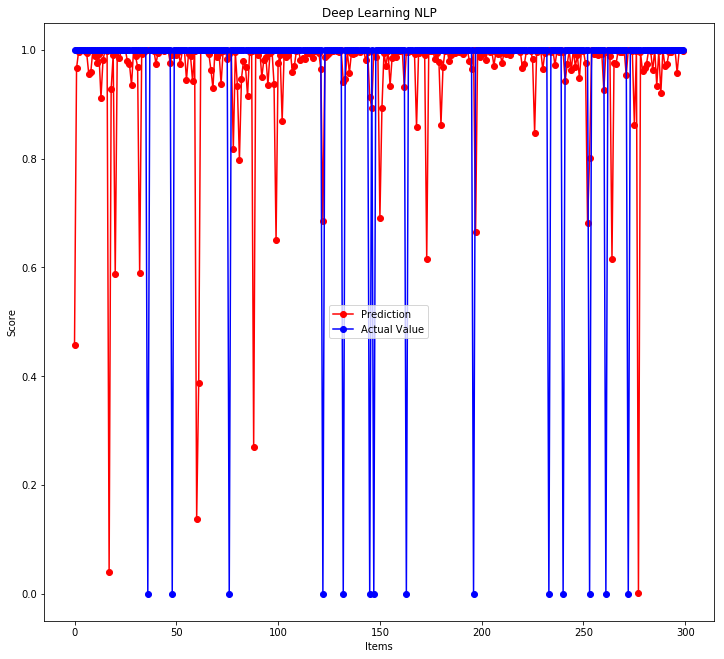

In [14]:
score_plot = plt.rcParams["figure.figsize"]
 
print("Current size:", score_plot)
 
score_plot[0] = 12
score_plot[1] = 11
plt.rcParams["figure.figsize"] = score_plot

plt.plot(y_pred_keras[:300], '-or', label='Prediction')
plt.plot(y_train_kera[:300], '-ob', label='Actual Value')
plt.ylabel('Score')
plt.xlabel('Items') 
plt.legend()
plt.title("Deep Learning NLP")

In [15]:
acc = graph_kera.history['acc']
val_acc = graph_kera.history['val_acc']
loss = graph_kera.history['loss']
val_loss = graph_kera.history['val_loss']

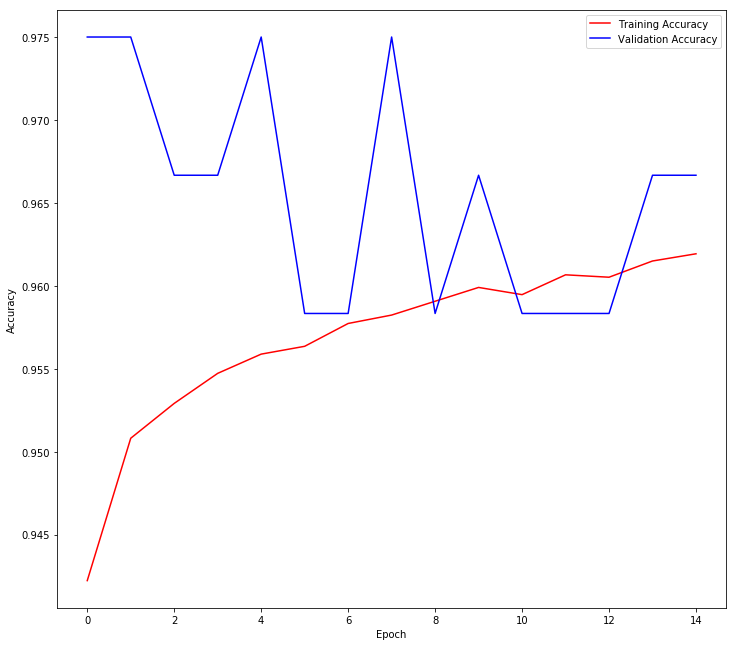

In [16]:
plt.plot(acc, 'r', label='Training Accuracy')
plt.plot(val_acc, 'b', label='Validation Accuracy')
#plt.plot(loss, 'b', label='Training loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch') 
plt.legend()


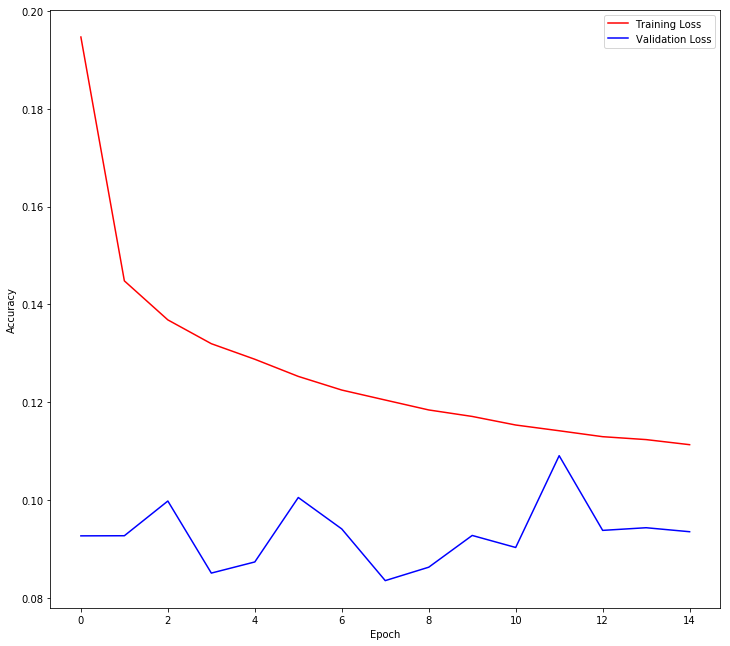

In [17]:
plt.plot(loss, 'r', label='Training Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
#plt.plot(loss, 'b', label='Training loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch') 
plt.legend()



In [23]:
all_words = []
for index in range(df['newComments'].size):
    all_words.append(df['newComments'][index])


In [24]:
all_words[0]

'this product far disappoint my children love use i like abil monitor control content see eas'

In [25]:
X_process = TVec.fit_transform(all_words).toarray()

In [26]:
df['newComments'][df['newComments'] == ''].index

Int64Index([3111, 9705, 34660], dtype='int64')

In [29]:
df['newComments'].isna().any()

False

In [32]:
y_rating = df['reviews.rating'].astype(np.int64)

In [36]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_process, y_rating, test_size = 0.25, random_state = 0)

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
tree_rms = sqrt(mean_squared_error(y_pred_tree, y_test))



In [37]:
tree_rms

0.8427614977397028

In [39]:
y_pred_tree = y_pred_tree.tolist()

In [42]:

from sklearn.metrics import f1_score
tree_f1 = f1_score(y_pred_tree, y_test, average='weighted')
print(f1_score(y_pred_tree, y_test, average='weighted'))

0.6283272269330842


In [51]:
y_test = y_test.tolist()

Current size: [12.0, 11.0]


Text(0.5,1,'Decision Tree Sentiment Analysis')

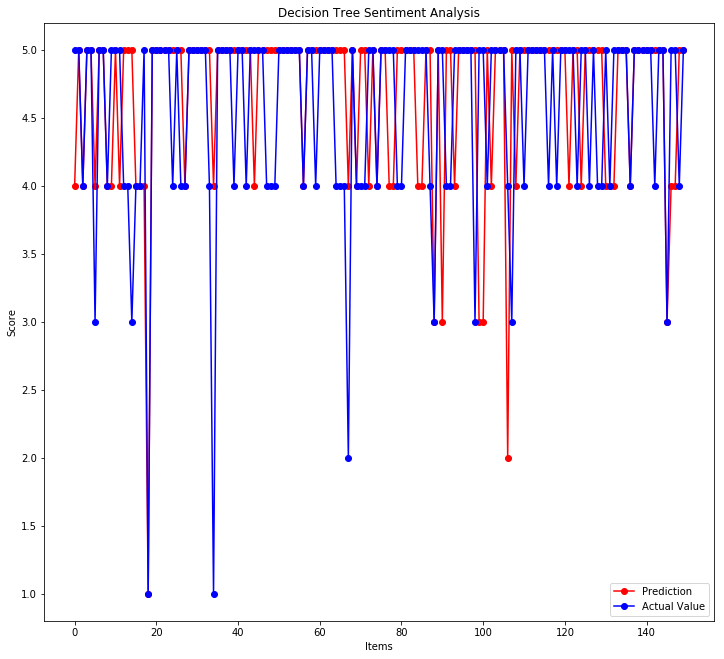

In [58]:
score_plot = plt.rcParams["figure.figsize"]
 
print("Current size:", score_plot)
 
score_plot[0] = 12
score_plot[1] = 11
plt.rcParams["figure.figsize"] = score_plot

plt.plot(y_pred_tree[:150], '-or', label='Prediction')
plt.plot(y_test[:150], '-ob', label='Actual Value')
plt.ylabel('Score')
plt.xlabel('Items') 
plt.legend()
plt.title("Decision Tree Sentiment Analysis")

In [18]:
pd.options.display.max_columns = None
display(df)

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,newComments
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",,1,,0,5.000000,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,,,Adapter,this product far disappoint my children love u...
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",,1,,0,5.000000,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,,,truman,great beginn experienc person bought gift love
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",,1,,0,5.000000,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,,,DaveZ,inexpens tablet use learn step nabi he thrill ...
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",,1,,0,4.000000,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,,,Shacks,i fire hd two week i love this tablet great va...
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",,1,,0,5.000000,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,,,explore42,i bought grand daughter come visit i set user ...
5,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",,1,,0,5.000000,http://reviews.bestbuy.com/3545/5620406/review...,This amazon fire 8 inch tablet is the perfect ...,Just what we expected,,,tklit,this amazon fire inch tablet perfect size i pu...
6,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",,1,,0,4.000000,http://reviews.bestbuy.com/3545/5620406/review...,"Great for e-reading on the go, nice and light ...",great e-reader tablet,,,Droi,great e read go nice light weight price point ...
7,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-0

In [19]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [25]:

def generate_word_cloud(data, color = 'black'):
    
    words = ' '.join(data)
    processed_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=3000,
                      height=2500
                     ).generate(processed_word)
    plt.figure(1,figsize=(15, 14))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()


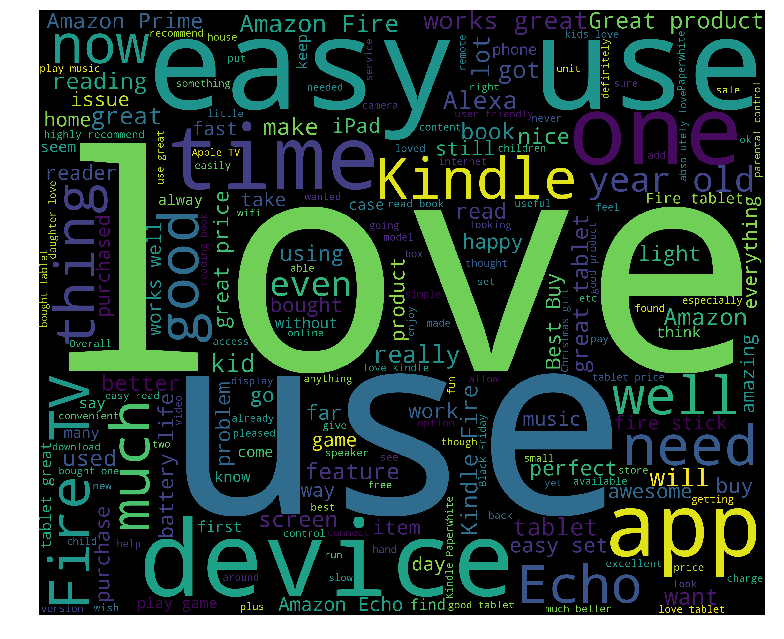

In [27]:
generate_word_cloud(df["reviews.text"],'black')


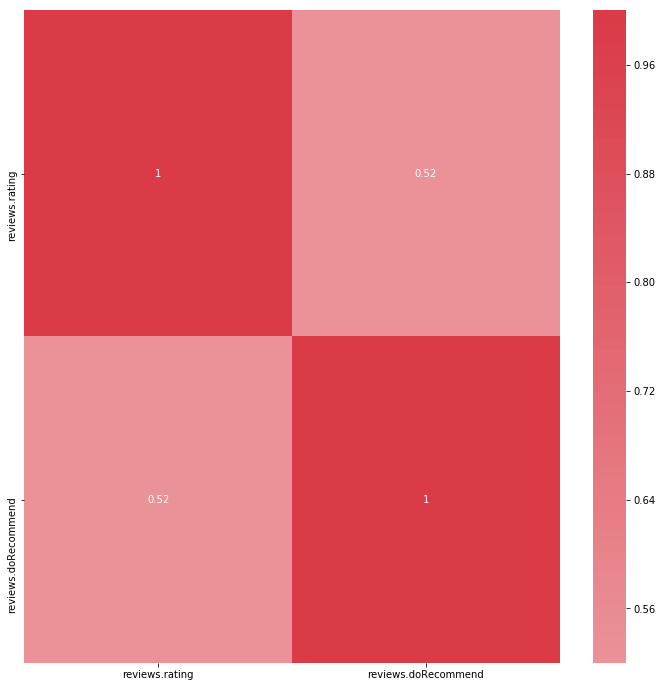

In [82]:
import seaborn as sns

numeric_features = ['reviews.rating']
ordinal_features = ['reviews.doRecommend', 'brand', 'name']
nominal_features = ['name', 'categories', 'brand']
cor_matrix = df[numeric_features + ordinal_features + nominal_features].corr().round(2)
# Plotting heatmap 
fig = plt.figure(figsize=(12,12));
sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
plt.show()

In [120]:
from sklearn_pandas import CategoricalImputer
imputerCategorical = CategoricalImputer()
df.replace(' ', np.nan, inplace=True)
df['brand'] = imputerCategorical.fit_transform(df['brand'])

In [121]:
brand_type = df.groupby("brand")
brand_type.describe().head(5)

reviews.doRecommend                           \
                                           count      mean       std  min   
brand                                                                       
                                             1.0  0.000000       NaN  0.0   
Amazon                                   28701.0  0.938957  0.239414  0.0   
Amazon Coco T                                1.0  0.000000       NaN  0.0   
Amazon Digital Services Inc.                10.0  0.000000  0.000000  0.0   
Amazon Echo                                636.0  0.926101  0.261813  0.0   

                                                 reviews.rating            \
                              25%  50%  75%  max          count      mean   
brand                                                                       
                              0.0  0.0  0.0  0.0            1.0  4.584573   
Amazon                        1.0  1.0  1.0  1.0        28701.0  4.564744   
Amazon Coco T                 0.0  0.0  0.0  0.0            1.0  4.584573   
Amazon Digital Services Inc.  0.0  0.0  0.0  0.0           10.0  3.500000   
Amazon Echo                   1.0  1.0  1.0  1.0          636.0  4.531447   

                                                                      \
                                   std       min       25%       50%   
brand                                                                  
                                   NaN  4.584573  4.584573  4.584573   
Amazon                        0.746727  1.000000  4.000000  5.000000   
Amazon Coco T                      NaN  4.584573  4.584573  4.584573   
Amazon Digital Services Inc.  1.840894  1.000000  1.500000  4.500000   
Amazon Echo                   0.819421  1.000000  4.000000  5.000000   

                                                  
                                   75%       max  
brand                                             
                              4.584573  4.584573  
Amazon                        5.000000  5.000000  
Amazon Coco T                 4.584573  4.584573  
Amazon Digital Services Inc.  5.000000  5.000000  
Amazon Echo                   5.000000  5.000000

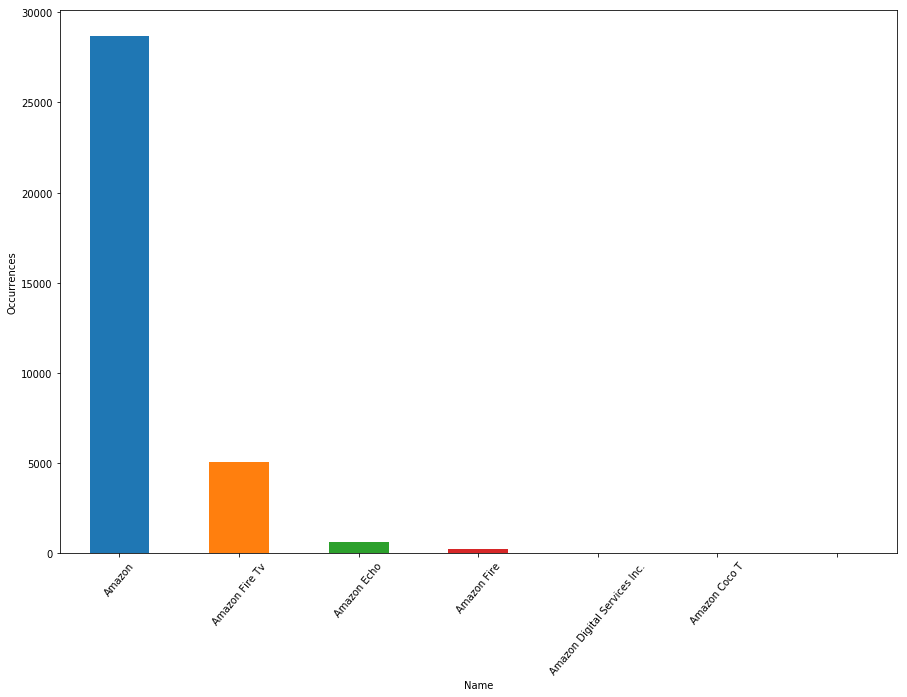

In [122]:
plt.figure(figsize=(15,10))
brand_type.size().sort_values(ascending=False).plot.bar()
#df['categories'].value_counts().head(10).plot('bar')
plt.xticks(rotation=50)
plt.xlabel("Name")
plt.ylabel("Occurrences")
plt.show()

In [79]:
df['reviews.doRecommend']

0        1
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16       1
17       1
18       1
19       1
20       1
21       1
22       1
23       1
24       1
25       1
26       1
27       1
28       1
29       1
        ..
34631    0
34632    0
34633    0
34634    0
34635    0
34636    0
34637    0
34638    0
34639    0
34640    0
34641    0
34642    0
34643    0
34644    0
34645    0
34646    0
34647    0
34648    0
34649    0
34650    0
34651    0
34652    0
34653    0
34654    0
34655    0
34656    0
34657    0
34658    0
34659    0
34660    0
Name: reviews.doRecommend, Length: 34661, dtype: int64

In [29]:
data = spark.createDataFrame(df)

In [30]:
data = data.select('id', '`reviews.rating`', 'name', 'newComments', "`reviews.doRecommend`")
data.printSchema()
data.show(5)

root
 |-- id: string (nullable = true)
 |-- reviews.rating: double (nullable = true)
 |-- name: string (nullable = true)
 |-- newComments: string (nullable = true)
 |-- reviews.doRecommend: long (nullable = true)

+--------------------+--------------+--------------------+--------------------+-------------------+
|                  id|reviews.rating|                name|         newComments|reviews.doRecommend|
+--------------------+--------------+--------------------+--------------------+-------------------+
|AVqkIhwDv8e3D1O-lebb|           5.0|All-New Fire HD 8...|this product far ...|                  1|
|AVqkIhwDv8e3D1O-lebb|           5.0|All-New Fire HD 8...|great beginn expe...|                  1|
|AVqkIhwDv8e3D1O-lebb|           5.0|All-New Fire HD 8...|inexpens tablet u...|                  1|
|AVqkIhwDv8e3D1O-lebb|           4.0|All-New Fire HD 8...|i fire hd two wee...|                  1|
|AVqkIhwDv8e3D1O-lebb|           5.0|All-New Fire HD 8...|i bought grand da...|       

In [31]:
data.groupBy("`reviews.doRecommend`") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()
    

+-------------------+-----+
|reviews.doRecommend|count|
+-------------------+-----+
|                  1|32682|
|                  0| 1979|
+-------------------+-----+



In [32]:
label_encoder = LabelEncoder()

In [33]:
product_name = df['name']

In [34]:
data.groupBy("name") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()
    

+--------------------+-----+
|                name|count|
+--------------------+-----+
|Fire Tablet, 7 Di...|10966|
|                    | 6760|
|Echo (White),,,
...| 3309|
|Amazon Kindle Pap...| 3176|
|All-New Fire HD 8...| 2814|
|Amazon Fire Tv,,,...| 2527|
|Fire Kids Edition...| 1685|
|Brand New Amazon ...| 1038|
|Kindle Voyage E-r...|  580|
|Fire Tablet, 7 Di...|  372|
|Amazon - Amazon T...|  318|
|All-New Kindle E-...|  212|
|Amazon 5W USB Off...|  208|
|All-New Fire HD 8...|  158|
|Amazon Fire Hd 8 ...|  135|
|Amazon Fire Hd 10...|  128|
|Kindle Oasis E-re...|   67|
|Amazon 9W PowerFa...|   36|
|Kindle Paperwhite...|   30|
|Amazon - Kindle V...|   25|
+--------------------+-----+
only showing top 20 rows



In [35]:
from sklearn_pandas import CategoricalImputer

In [36]:
categorical_imputer = CategoricalImputer()

In [37]:
df['name'] = df['name'].replace('',np.nan, regex=True)
df['name']

0        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
1        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
2        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
3        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
4        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
5        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
6        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
7        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
8        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
9        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
10       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
11       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
12       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
13       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
14       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
15       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
16       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,.

In [38]:
df['name'] = categorical_imputer.fit_transform(df['name'])

In [39]:
df['name']

0        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
1        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
2        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
3        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
4        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
5        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
6        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
7        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
8        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
9        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
10       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
11       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
12       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
13       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
14       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
15       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
16       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,.

In [40]:
integer_encoded_name = label_encoder.fit_transform(df['name'])

In [41]:
integer_encoded_name

array([ 1,  1,  1, ..., 39, 39,  0])

In [42]:
import plotly

In [43]:
print(type(data))

<class 'pyspark.sql.dataframe.DataFrame'>


In [44]:
data.printSchema()

root
 |-- id: string (nullable = true)
 |-- reviews.rating: double (nullable = true)
 |-- name: string (nullable = true)
 |-- newComments: string (nullable = true)
 |-- reviews.doRecommend: long (nullable = true)



In [45]:
df['reviews.username'] = categorical_imputer.fit_transform(df['reviews.username'])

In [46]:
integer_encoded_userName = label_encoder.fit_transform(df['reviews.username'])

In [47]:
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import NormalPredictor

In [48]:
surprise_frame = pd.DataFrame(columns=['User','Item','Rating'])

In [49]:
surprise_frame['User'] = integer_encoded_userName.tolist()
surprise_frame['Item'] = integer_encoded_name.tolist()
surprise_frame['Rating'] = df['reviews.rating']

In [50]:
surprise_frame

,User,Item,Rating
0,551,1,5.000000
1,26305,1,5.000000
2,4565,1,5.000000
3,16218,1,4.000000
4,21569,1,5.000000
5,26176,1,5.000000
6,5270,1,4.000000
7,9425,1,5.000000
8,19028,1,5.000000
9,15280,1,5.000000


In [51]:
reader = Reader(line_format='user item rating',rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(surprise_frame[['User', 'Item', 'Rating']], reader)

In [52]:
surprise_data

In [53]:
cross_validate(NormalPredictor(), surprise_data, cv=2)


{'test_rmse': array([0.93866575, 0.93197129]),
 'test_mae': array([0.66785605, 0.66252242]),
 'fit_time': (0.022443771362304688, 0.02587294578552246),
 'test_time': (0.1892378330230713, 0.12955379486083984)}

In [54]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split

In [55]:
surprise_frame.to_csv("surprise_frame.csv", sep=',', encoding='utf-8', index=False)

In [56]:
reader2 = Reader(line_format='user item rating', sep = ',', rating_scale=(1, 5), skip_lines=1)


In [57]:
import os

In [58]:
file_path = os.path.expanduser('surprise_frame.csv')

In [59]:
surprise_data_2 = Dataset.load_from_file(file_path, reader=reader2)

In [60]:
surprise_data_2

In [61]:
trainset, testset = train_test_split(surprise_data_2, test_size=.25)

In [62]:
algo = SVD()

In [63]:
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)


RMSE: 0.7262


0.7262044128306727

In [64]:
algo.predict(str(550), str(0), verbose=True)

user: 550        item: 0          r_ui = None   est = 4.63   {'was_impossible': False}


Prediction(uid='550', iid='0', r_ui=None, est=4.625462576324475, details={'was_impossible': False})

In [65]:
algo.predict(str(26304), str(0), verbose=True)

user: 26304      item: 0          r_ui = None   est = 4.54   {'was_impossible': False}


Prediction(uid='26304', iid='0', r_ui=None, est=4.536584153777477, details={'was_impossible': False})

In [66]:
algo.predict(str(4564), str(0), verbose=True)

user: 4564       item: 0          r_ui = None   est = 4.57   {'was_impossible': False}


Prediction(uid='4564', iid='0', r_ui=None, est=4.573317878447463, details={'was_impossible': False})